Machine Learning Stripped Helium Stars.  
--- 
By Bethany Ann Ludwig  
Theoretical Data is provided by Ylva Gotberg.  
Optical Data is from the MCPS Survey.  
UV data was created by our group with the Swift UVOT images. 


### Stripped Helium Stars are stars that have had their outer hydrogen envelope removed by a companion

![top](top.gif)

### We know that this process causes the mass loser to be hot and blue and, theoretically, should lie *bluewards of the main sequence.*

<img src="TheoryCMD.png" alt="theorycmd" width="620" height="540"/>

### Previous photometry made it difficult to create these color magnitude diagrams because of problems with clustering.

<img src="Clustering.png" alt="clustering" width="620" height="540"/>

### But with a new technique, "The Tractor", we can make a model of the sky...

<img src="Tractor.png" alt="thetractor" width="1120" height="540"/>

### and create our own photometry!

<img src="CMD.png" alt="cmd" width="1120" height="540"/>

### But what if I told you... left of ZAMS *wasn't* the best way to identify stripped helium stars.

![morpheus](morpheus.gif "whatifitoldyou")

# Stripped Helium Star Identification Using T-Distributed Stochastic Neighbor Embedding and Support Vector Classification

In [31]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from IPython.display import HTML
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import time 

### Data Aquisition

In [17]:
# Get the photometry
theory = pd.read_csv("data2_run_Z0.002_10.txt",skiprows=0,delimiter="\s+")
theory = theory.drop(columns=['UVW2_BB_m1', 'UVW2_BB_m2', 'UVW2_spec_m1','UVW2_spec_m2', 'UVW2_spec_tot', 'UVM2_BB_m1', 'UVM2_BB_m2','UVM2_spec_m1', 'UVM2_spec_m2', 'UVM2_spec_tot',
       'UVW1_BB_m1', 'UVW1_BB_m2', 'UVW1_spec_m1', 'UVW1_spec_m2', 'UVW1_spec_tot', 'U_BB_m1', 'U_BB_m2', 'U_spec_m1', 'U_spec_m2', 'U_spec_tot', 'B_BB_m1', 'B_BB_m2',
       'B_spec_m1', 'B_spec_m2', 'B_spec_tot', 'V_BB_m1', 'V_BB_m2', 'V_spec_m1', 'V_spec_m2', 'V_spec_tot','R_BB_m1', 'R_BB_m2', 'R_spec_m1', 'R_spec_m2',
       'R_spec_tot', 'I_BB_m1', 'I_BB_m2',  'I_spec_m1', 'I_spec_m2', 'I_spec_tot', 'J_BB_m1', 'J_BB_m2', 'J_spec_m1', 'J_spec_m2', 'J_spec_tot', 'H_BB_m1', 'H_BB_m2',
       'H_BB_tot', 'H_spec_m1', 'H_spec_m2', 'H_spec_tot', 'Ks_BB_m1','Ks_BB_m2',  'Ks_spec_m1', 'Ks_spec_m2', 'Ks_spec_tot']);
theory = theory.replace([np.inf, -np.inf,'inf',''], np.nan).dropna(axis=0,how='any')

# Get the labels
labels = pd.read_csv("data1_run_Z0.002_10.txt",skiprows=0,delimiter="\s+")
labels = labels.drop(columns=['M1init', 'M2init', 'Pinit', 'M1', 'M2', 'P', 'actual_age', 'apparent_age1', 'apparent_age2', 'log_Teff_1', 'log_Teff_2', 'logg_1', 'logg_2',
       'log_R_1', 'log_R_2', 'log_L_1', 'log_L_2', 'log_abs_mdot_1', 'log_abs_mdot_2', 'XHs_1', 'XHs_2', 'XHes_1', 'XHes_2', '-', '-.1', '-.2', '-.3'])

# Merge the two datasets
data = theory.merge(labels,on="Star_ID")

# Create Numerical Labels
data["Labels"] = np.zeros(data.shape[0])

# If one of the star states is not 2, then it is not a stripped star.
data.loc[(data["Star_state_m1"] == 2) | (data["Star_state_m2"] == 2), "Labels"] = 2
 
# ZAMS
ZAMS = pd.read_csv("ZAMS_Z0.002.txt",delimiter="\s+")
ZAMS = ZAMS.replace([np.inf, -np.inf,'inf','','-'], np.nan).dropna(axis=0,how='any')

# Reduction 
#data = data.drop(data[(data["UVM2_BB_tot"] - data["V_BB_tot"]) > 2].index).reset_index()

# Convert to Apparent
def app(mag):
    return mag + 5 *np.log10(60000/10)

for label in ['UVW2_BB_tot', 'UVM2_BB_tot', 'UVW1_BB_tot', 'U_BB_tot', 'B_BB_tot', 'V_BB_tot', 'R_BB_tot', 'I_BB_tot', 'J_BB_tot', 'Ks_BB_tot']:
    data[label] = app(data[label].astype(float))
for label in ['UVW2_BB', 'UVW2_spec', 'UVM2_BB', 'UVM2_spec', 'UVW1_BB',
       'UVW1_spec', 'U_BB', 'U_spec', 'B_BB', 'B_spec', 'V_BB', 'V_spec',
       'R_BB', 'R_spec', 'I_BB', 'I_spec', 'J_BB', 'J_spec', 'H_BB', 'H_spec',
       'Ks_BB', 'Ks_spec']:
    ZAMS[label] = app(ZAMS[label].astype(float))
# Display Data
data.head()

,Star_ID,UVW2_BB_tot,UVM2_BB_tot,UVW1_BB_tot,U_BB_tot,B_BB_tot,V_BB_tot,R_BB_tot,I_BB_tot,J_BB_tot,Ks_BB_tot,Star_state_m1,Star_state_m2,Evolution,Labels
0,34.0,18.166714,18.691977,18.146009,18.863487,19.490804,19.921737,19.625975,20.005626,18.792293,17.679212,2,64,strip_RLOF_HG,2.0
1,836.0,12.886340,13.307593,12.693459,13.186114,13.737554,14.098618,13.767340,14.103073,12.856407,11.743326,1,1,strip_RLOF_MS,0.0
2,886.0,16.548326,16.715001,15.862009,15.747985,16.069509,16.220056,15.780409,15.983685,14.636971,13.523889,1,1,merger_HG,0.0
3,1084.0,18.136431,18.282120,17.399120,17.216979,17.507824,17.629796,17.175150,17.360294,16.000030,14.886949,1,1,merger_HG,0.0
4,1272.0,16.321435,16.546300,15.758096,15.788698,16.167733,16.370766,15.958438,16.195043,14.873601,13.760519,1,1,merger_HG,0.0


### A first look at the data, indicates that we can simplify these labels into stripped and not stripped stars. 

Text(0.5, 0, 'UVM2 - V')

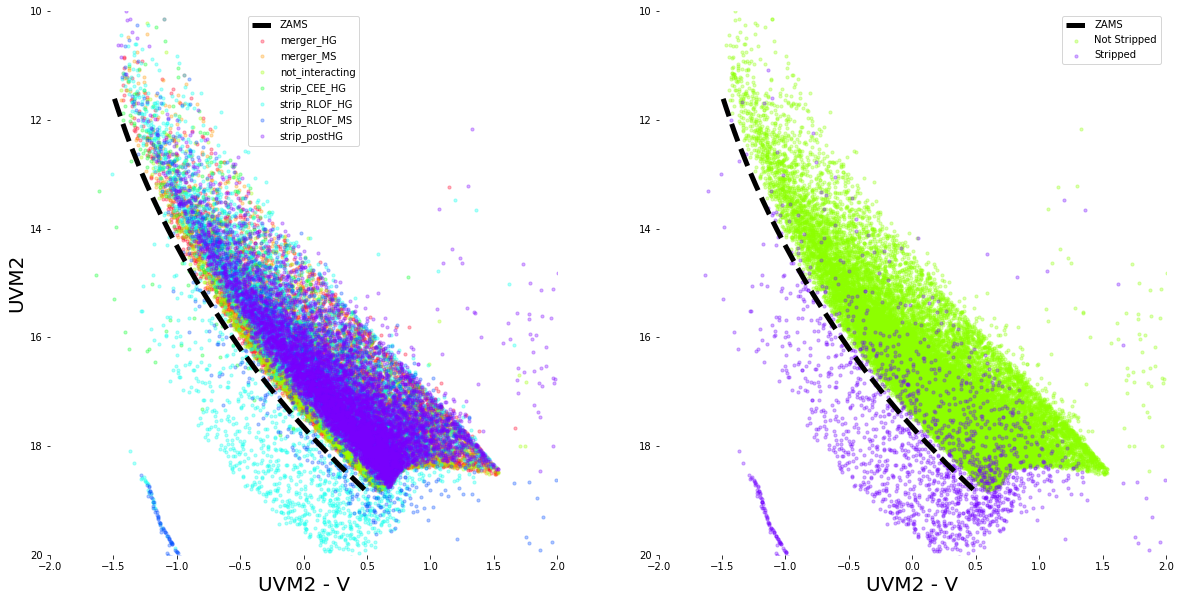

In [20]:
evolution_labels = np.unique(data.Evolution)
numerical_labels = ["Not Stripped", "Stripped"]
# Get data by all evolutionary states
UVM2_ALL = [data.loc[data["Evolution"] == state,"UVM2_BB_tot"].astype(float) for state in evolution_labels]
V_ALL = [data.loc[data["Evolution"] == state,"V_BB_tot"] for state in evolution_labels]
# Get data by stripped vs not stripped
UVM2_STRIP = [data.loc[data["Labels"] == state,"UVM2_BB_tot"].astype(float) for state in [0,2]]
V_STRIP = [data.loc[data["Labels"] == state,"V_BB_tot"] for state in [0,2]]

 



f, (ax,bx) = plt.subplots(1,2,figsize=(20,10))
cmap = cm.get_cmap("gist_rainbow"); twocolor = [0.3,0.85]
[ax.scatter(UVM2_ALL[i] - V_ALL[i], UVM2_ALL[i], label=evolution_labels[i],alpha=0.3 ,s=10,c=[cmap(i/7)]) for i in range(len(evolution_labels))]
[ax.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
[bx.scatter(UVM2_STRIP[i] - V_STRIP[i], UVM2_STRIP[i], label=numerical_labels[i],alpha=0.3, c=[cmap(twocolor[i])],s=10)for i in range(len(numerical_labels))]
[bx.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]

# ZAMS 
ax.plot(ZAMS.UVM2_BB - ZAMS.V_BB,ZAMS.UVM2_BB,linewidth=5,c="black",label="ZAMS",linestyle="--")
bx.plot(ZAMS.UVM2_BB - ZAMS.V_BB,ZAMS.UVM2_BB,linewidth=5,c="black",label="ZAMS",linestyle="--")


ax.set_ylim(20,10); bx.set_ylim(20,10)
ax.set_xlim(-2,2); bx.set_xlim(-2,2)
ax.legend(); bx.legend()
ax.set_ylabel("UVM2",fontsize=20)
ax.set_xlabel("UVM2 - V",fontsize=20); bx.set_xlabel("UVM2 - V",fontsize=20)
#plt.ylim(3,-7)

### Separating distinct groups by eye, isn't easy. 

[None, None]

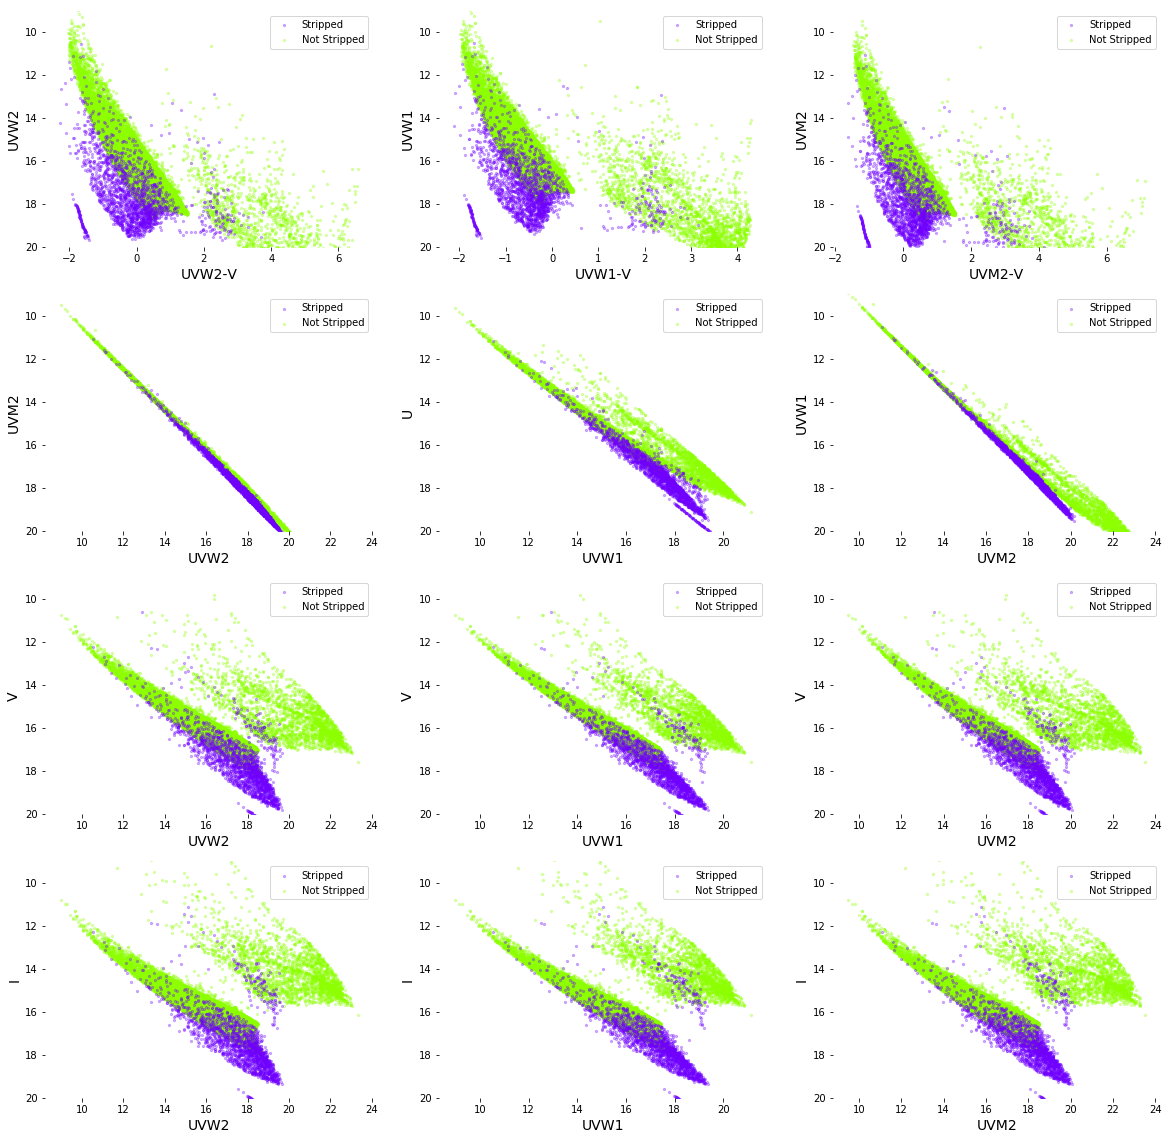

In [21]:
stripped = data.loc[data["Labels"] == 2]
notstripped = data.loc[data["Labels"] == 0]

def plot(axis,X,Y,Xlabel,Ylabel,Stripped):
    if Stripped:
        axis.scatter(X,Y,c=[cmap(twocolor[1])], s=5,alpha=0.3,label="Stripped",zorder=1)
    else:
        axis.scatter(X,Y,c=[cmap(twocolor[0])], s=5,alpha=0.3,label="Not Stripped",zorder=0)

    #axis.set_ylim(axis.get_ylim()[::-1])
    [axis.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
    axis.set_ylim(20,9)
    axis.set_ylabel(Ylabel,fontsize=14); axis.set_xlabel(Xlabel,fontsize=14)
    axis.legend()
    

f, axes = plt.subplots(4,3,figsize=(20,20))

[plot(axes[0,0],df["UVW2_BB_tot"].astype(float) - df["V_BB_tot"],df["UVW2_BB_tot"].astype(float),"UVW2-V","UVW2",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[0,1],df["UVW1_BB_tot"].astype(float) - df["V_BB_tot"],df["UVW1_BB_tot"].astype(float),"UVW1-V","UVW1",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[0,2],df["UVM2_BB_tot"].astype(float) - df["V_BB_tot"],df["UVM2_BB_tot"].astype(float),"UVM2-V","UVM2",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[1,0],df["UVW2_BB_tot"].astype(float),df["UVM2_BB_tot"].astype(float),"UVW2","UVM2",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[1,1],df["UVW1_BB_tot"].astype(float),df["U_BB_tot"].astype(float),"UVW1","U",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[1,2],df["UVM2_BB_tot"].astype(float),df["UVW1_BB_tot"].astype(float),"UVM2","UVW1",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[2,0],df["UVW2_BB_tot"].astype(float),df["V_BB_tot"].astype(float),"UVW2","V",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[2,1],df["UVW1_BB_tot"].astype(float),df["V_BB_tot"].astype(float),"UVW1","V",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[2,2],df["UVM2_BB_tot"].astype(float),df["V_BB_tot"].astype(float),"UVM2","V",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[3,0],df["UVW2_BB_tot"].astype(float),df["I_BB_tot"].astype(float),"UVW2","I",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[3,1],df["UVW1_BB_tot"].astype(float),df["I_BB_tot"].astype(float),"UVW1","I",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[3,2],df["UVM2_BB_tot"].astype(float),df["I_BB_tot"].astype(float),"UVM2","I",condition) for condition, df in zip([True,False],[stripped,notstripped])]


## Dimensionality Reduction with t-SNE - All Data

In [22]:
X = data[['UVW2_BB_tot', 'UVM2_BB_tot', 'UVW1_BB_tot',
       'U_BB_tot', 'B_BB_tot', 'V_BB_tot', 'R_BB_tot', 'I_BB_tot', 'J_BB_tot',
       'Ks_BB_tot']]
print(X.shape)

(37023, 10)


### Perplexity is a tunable parameter related to the number of nearest neighbors. 
  
#### In most cases, increasing the perplexity also increases the tendency towards clearer shapes. 

In [23]:
start = time.time()
X_embedded = [TSNE(n_components = 2, perplexity = perplex, init = 'random', random_state=0).fit_transform(X) for perplex in [30,50,100,150]]
print("Time Taken:" + str(time.time() - start)+" s")

Time Taken:2737.832021713257 s


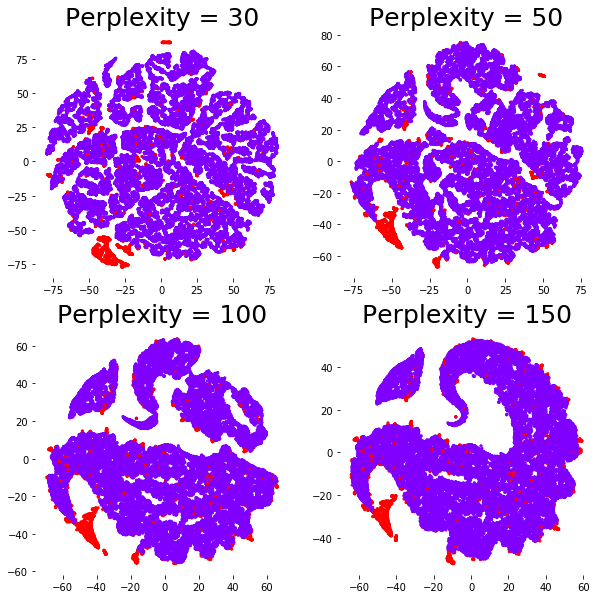

In [24]:
f, axes = plt.subplots(2,2,figsize=(10,10))
counter = 0 ; perplexity = [30,50,100,150]
for i in np.arange(2):
    for j in np.arange(2):
        axes[i,j].scatter(X_embedded[counter][:,0],X_embedded[counter][:,1],c=data["Labels"],s=5,cmap="rainbow")
        axes[i,j].set_title("Perplexity = " + str(perplexity[counter]),fontsize=25)
        [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
        counter += 1

## Dimensionality Reduction with t-SNE - Running PCA First

In [25]:
pca = PCA(n_components = 2)
pca.fit(X)
X_reduced = pca.transform(X)
comp = pca.components_
print(X_reduced.shape)

(37023, 2)


[None, None, None, None]

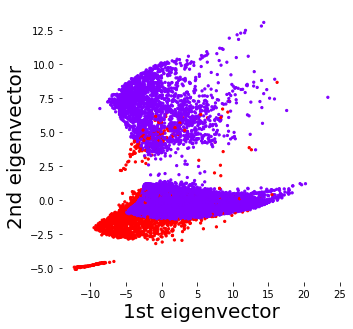

In [26]:
cmap="rainbow"

fig = plt.figure(1, figsize=(5, 5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data["Labels"],cmap=cmap,s=5)
ax.set_xlabel("1st eigenvector",fontsize=20)
ax.set_ylabel("2nd eigenvector",fontsize=20)
ax.set_facecolor('white')
[ax.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]

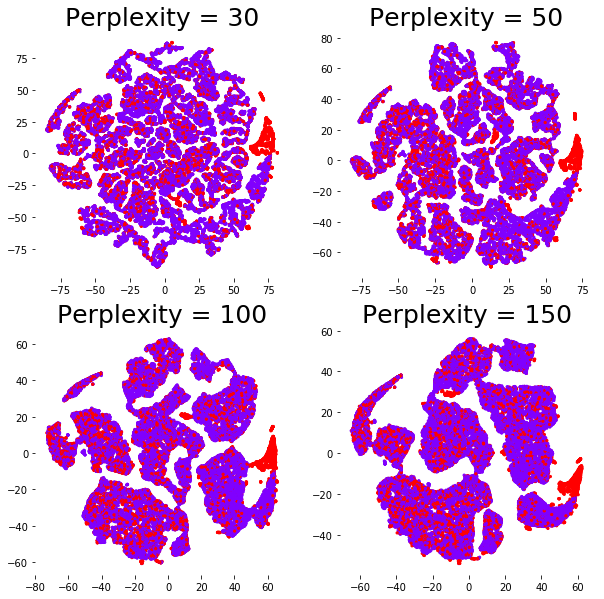

In [32]:
start = time.time()
X_embed_reduc = [TSNE(n_components = 2, perplexity = perplex, init = 'random', random_state=0).fit_transform(X_reduced) for perplex in [30,50,100,150]]
print("Time Taken:" + str(time.time() - start)+" s")

f, axes = plt.subplots(2,2,figsize=(10,10))
counter = 0 ; perplexity = [30,50,100,150]
for i in np.arange(2):
    for j in np.arange(2):
        axes[i,j].scatter(X_embed_reduc[counter][:,0],X_embed_reduc[counter][:,1],c=data["Labels"],s=5,cmap="rainbow")
        axes[i,j].set_title("Perplexity = " + str(perplexity[counter]),fontsize=25)
        [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
        counter += 1

## Other things I've tried...

There are various other "Manifold Learning" techniques. All but Linear Embedded Manifold learning resulted in memory errors. 

### It's possible a neural net could work...

In [65]:
y = data["Labels"]
# Splitting up data into training and testing
kf = KFold(n_splits=2, shuffle=True, random_state = 1)

train_index, test_index =  kf.split(X)
    
X_train, X_test = X.iloc[list(train_index[0])], X.iloc[list(train_index[1])]
y_train, y_test = y[list(train_index[0])], y[list(train_index[1])]

In [69]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20), random_state=1)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)

In [82]:
from sklearn.metrics import completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import confusion_matrix

def confusionPlot(y_true,y_pred): # Mostly From Confusion Matrix Example from SciKit Learn
    cm = confusion_matrix(y_test,y_predict)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = ["Not Stripped","Stripped"]
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor",fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
   # ax.set_xlabel(fontsize=20)
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j],'.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",fontsize=20)
    fig.tight_layout()

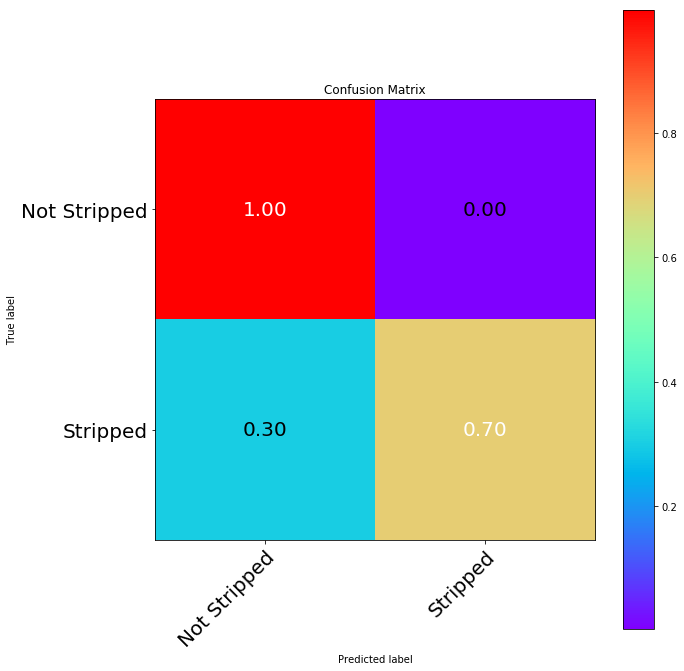

In [83]:
confusionPlot(y_test,y_predict)